In [1]:
from astropy import constants as const
from astropy import units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import scipy.integrate as integrate
from scipy.optimize import curve_fit 
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import random

### Punto 1
Guardamos primero cada distancia en una lista con sus unidades respectivas:

In [2]:
d=[]
d.append(150e6*u.km)
d.append(7.9*u.kpc)
d.append(50*u.kpc)
d.append(14*u.Mpc)
d.append(53*u.Mpc)
d.append(113*u.Mpc)

Guardamos en otra lista el tiempo que demora la luz en recorrer las distancias hasta la tierra. Lo anterior teniendo en cuenta la velocidad de la luz en el vacío y las unidades:

In [3]:
t=[]
for i in range(len(d)):
    if d[i].unit=="km":
        t.append(d[i]/const.c.to(u.km/u.min))
    if d[i].unit=="kpc":
        t.append(d[i]/const.c.to(u.kpc/u.yr))
    if d[i].unit=="Mpc":
        t.append(d[i]/const.c.to(u.Mpc/u.yr))

Mostramos los resultados en una tabla:

In [4]:
tab=pd.DataFrame(t,['Desde el sol','Desde el centro de la vía Láctea','Desde la gran nube de magallanes',\
                    'Desde la galaxia NGC 4649','Desde el cúmulo de galaxias de Pegaso', \
                    'Desde el cúmulo de Leo'],['Tiempo-luz'])
tab.head()

,Tiempo-luz
Desde el sol,8.3391023799538 min
Desde el centro de la vía Láctea,25766.353839420848 yr
Desde la gran nube de magallanes,163078.18885709398 yr
Desde la galaxia NGC 4649,45661892.879986316 yr
Desde el cúmulo de galaxias de Pegaso,172862880.18851963 yr


### Punto 2
Por las condiciones dadas supongamos que $$y=mx$$
Para el ajuste la idea es minimizar $S(m)$:
$$S(m)=\sum_{i=0}^n(y_i-mx_i)^2=\sum_{i=0}^n(y_i^2-2y_imx_i+m^2x_i^2)$$
El óptimo de $m$ vendría dado por:
$$\frac{dS}{dm}=\sum_{i=0}^n-2(y_ix_i-mx_i^2)=2\left(m\sum_{i=0}^nx_i^2-\sum_{i=0}^ny_ix_i\right)=0 \implies m\sum_{i=0}^nx_i^2-\sum_{i=0}^ny_ix_i=0 \implies m=\frac{\sum_{i=0}^ny_ix_i}{\sum_{i=0}^nx_i^2}$$

### Punto 3
Ingresamos primero los datos de [Hubble](https://www.pnas.org/content/pnas/15/3/168.full.pdf?guid=on):

In [5]:
d=np.array([0.032,0.034,0.214,0.263,0.275,0.275,0.45,0.5,0.5,0.63,0.8,0.9,0.9,0.9,0.9,1,1.1,1.1,1.4,1.7,2,2,\
           2,2])
v=np.array([170,290,-130,-70,-185,-220,200,290,270,200,300,-30,650,150,500,920,450,500,500,960,500,850,800,\
           1090])

Calculamos ahora la pendiente de la recta ajustada a los datos anteriores de la forma $y=mx$, usando el punto anterior:

In [6]:
num=0
den=0
for i in range(len(d)):
    num+=d[i]*v[i]
    den+=d[i]**2
m=num/den

Grafiquemos ahora los datos anteriores junto con la recta ajustada a los mismos:

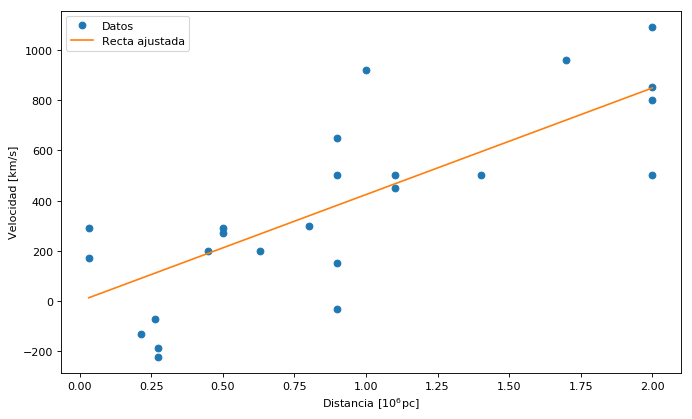

In [7]:
def f(x):
    return m*x
x=np.linspace(d.min(),d.max(),50)
y=np.zeros(len(x))
for i in range(len(x)):
    y[i]=f(x[i])
plt.figure(figsize=(10,6), dpi=80)
plt.plot(d,v,'o',x,y,'-')
plt.xlabel(r'Distancia [$10^6$pc]')
plt.ylabel('Velocidad [km/s]')
plt.legend(('Datos','Recta ajustada'),loc=0)
plt.show()

Obtengamos ahora $H_0$ en las unidades pedidas:

In [8]:
m=m*(u.km/(u.s*1e6*u.pc))
M=m.to(u.km/(u.s*u.Mpc))
M

<Quantity 423.93732323 km / (Mpc s)>

### Punto 4
Note que $\displaystyle t_0=\frac{1}{H_0}$, así el tiempo de Hubble será:

In [9]:
1/M.to(u.km/(u.s*u.km))

<Quantity 7.27861741e+16 s>

In [10]:
(1/M.to(u.km/(u.s*u.km))).to(u.yr).value

2306454676.41188

### Punto 5


Ingresemos primero los datos de la información dada:

In [11]:
dat=np.loadtxt("data.txt",skiprows=5,usecols=(1,2,3))
rojo=dat[:,0]
mod=dat[:,1]
er=dat[:,2]

Obtenemos $v$ y $D_L$ teniendo en cuenta que $v=zc$ y $D_L=10^{\frac{\mu}{5}-5}$:

In [12]:
d=[]
v=[]
for i in range(len(mod)):
    d.append(10**((mod[i]/5)-5))
    v.append(rojo[i]*const.c.value)

Graficamos los datos obtenidos:

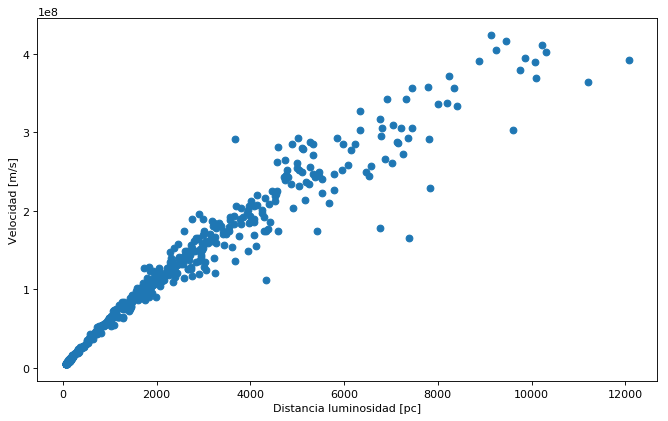

In [13]:
plt.figure(figsize=(10,6), dpi=80)
plt.plot(d,v,'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel('Velocidad [m/s]')
plt.show()

De la gráfica podemos notar que hasta cierta distancia (entre 0pc y 4,000pc) los datos parecen tener un comportamiento lineal de acuerdo con la ley de Hubble-Lemaitre, la idea ahora es encontrar dicha distancia. Para ello, ajustemos los datos a una recta de la forma $v=mD_L$: considerando primero los tres primeros valores de $D_L$, después los cuatro primeros valores de $D_L$, luego los cinco primero valores de $D_L$ y así sucesivamente. Lo anterior para registrar los valores de $m$ y de la suma de los residuales cuadráticos a medida que consideramos las primeras $i$-ésimas distancias, así hasta considerar todas.

Primero ordenemos los datos de distancia, velocidad y error en orden ascendente:

In [14]:
a=np.sort(d)
b=[]
c=[]
for i in range(len(a)):
    b.append(v[d.index(a[i])])
    c.append(er[d.index(a[i])])
d.sort()
v=b
er=c

Guardemos ahora en las listas $\mathtt{r} \ \text{y} \ \mathtt{\text{H_0}}$ la suma de los residuales cuadráticos y la pendiente de la recta ajustada, respectivamente; para cada ajuste hasta la $i$-ésima distancia considerada:

In [15]:
def f(x,m):
    return m*x
r=[99999999999999,999999999999999]
H_0=r.copy()
for i in range(3,len(d)+1):
    D=d[:i]
    V=v[:i]
    popt,pcov=curve_fit(f,D,V)
    M=popt[0]
    H_0.append(M)
    
    res=[]
    for j in range(len(D)):
        res.append((V[j]-M*D[j])**2)
    r.append(np.sum(res))

Ahora gráficamente veamos los distintos valores de $H_0$ arrojados por cada ajuste para datos considerados. La idea es acotar cada vez las distancias en las cuales se observe un comportamiento constante de $H_0$ (gráficos a la izquierda), considerando la suma de los residuales cuadráticos del ajuste hasta esas distancias (gráficos de la derecha). Resaltado vemos el intervalo de datos a considerar para la gráfica siguiente:

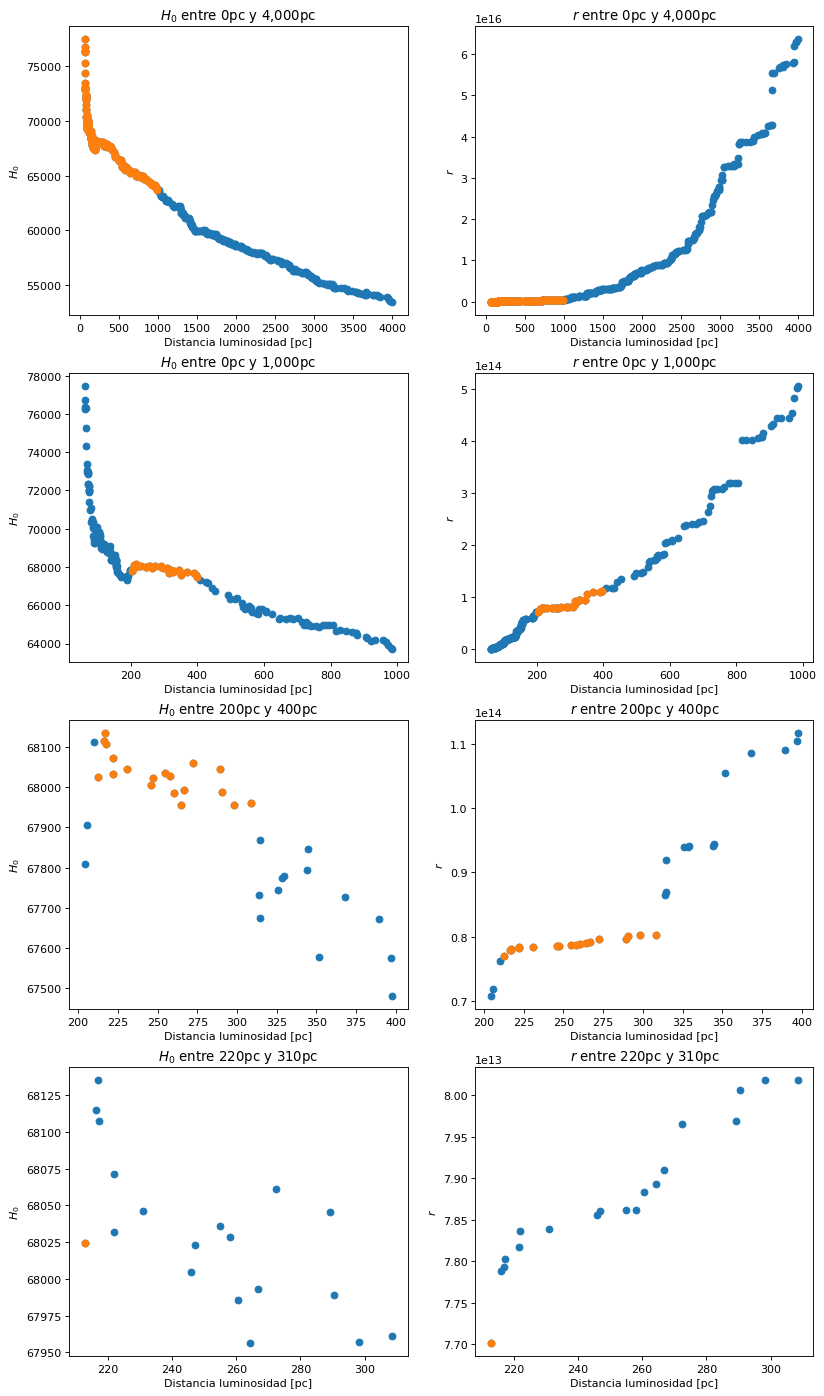

In [16]:
plt.figure(figsize=(12,45), dpi=80)

plt.subplot(821)
plt.plot(d[2:469],H_0[2:469],'o',d[2:230],H_0[2:230],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 0pc y 4,000pc')

plt.subplot(822)
plt.plot(d[2:469],r[2:469],'o',d[2:230],r[2:230],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$r$')
plt.title(r'$r$ entre 0pc y 4,000pc')

plt.subplot(823)
plt.plot(d[2:230],H_0[2:230],'o',d[135:170],H_0[135:170],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 0pc y 1,000pc')

plt.subplot(824)
plt.plot(d[2:230],r[2:230],'o',d[135:170],r[135:170],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$r$')
plt.title(r'$r$ entre 0pc y 1,000pc')

plt.subplot(825)
plt.plot(d[135:170],H_0[135:170],'o',d[138:157],H_0[138:157],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 200pc y 400pc')

plt.subplot(826)
plt.plot(d[135:170],r[135:170],'o',d[138:157],r[138:157],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$r$')
plt.title(r'$r$ entre 200pc y 400pc')

plt.subplot(827)
plt.plot(d[138:157],H_0[138:157],'o',d[138],H_0[138],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 220pc y 310pc')

plt.subplot(828)
plt.plot(d[138:157],r[138:157],'o',d[138],r[138],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$r$')
plt.title(r'$r$ entre 220pc y 310pc')

plt.show()

Veamos la información de esta dos últimas gráficas de forma más precisa:

In [17]:
print("Distancia         H_0       Sum. Residuales cuadráticos")
for i in range(138,157):
    print('{:f}'.format(d[i]),"  ",'{:f}'.format(H_0[i]),"  ",'{:f}'.format(r[i]))

Distancia         H_0       Sum. Residuales cuadráticos
212.840581    68024.296951    77021206161682.078125
216.203600    68114.648745    77890296293216.390625
217.006920    68135.503270    77938208844656.593750
217.353619    68107.565340    78027509060179.781250
221.833523    68071.602168    78175519988788.140625
221.982879    68032.007178    78362206151560.656250
230.960787    68046.240166    78385443258388.625000
245.972798    68005.053605    78564980815748.609375
247.015732    68023.417735    78602093448534.265625
254.991694    68035.991251    78619223264932.187500
258.022530    68028.783702    78624996643843.390625
260.646160    67985.975764    78834561744524.875000
264.441433    67956.660769    78934818413525.421875
266.808030    67993.270628    79096100579053.671875
272.333109    68061.411398    79659351489805.828125
289.293156    68045.353381    79688549057769.718750
290.528219    67988.865858    80066607231312.375000
298.140524    67957.010094    80187120606013.875000
308.5654

Escogemos como distancia límite para la validez de la ley de Hubble-Lemaitre 212.840pc pues es en esa distancia que es miníma la suma de los residuales del ajuste lineal en el intervalo considerado. Obtengamos ahora $H_0$ haciendo un ajuste lineal hasta dicha distancia teniendo en cuenta el error en las mediciones. Así,

$$S(H_0)=\sum_{i=0}^nW_i^2(v_i-H_0d_i)^2$$
Dado que se quiere minimizar $S(H_0)$:
$$H_0=\frac{\sum_{i=0}^nW_i^2v_id_i}{\sum_{i=0}^nW_i^2d_i^2}$$
Donde:
$$W_i=\frac{1}{\sigma} \qquad \sigma=\frac{d}{d\mu}\left[10^{\frac{\mu}{5}-5}\right]\sigma_\mu=\left[10^{\frac{\mu}{5}-5}\frac{\ln(10)}{5}\right]\sigma_\mu$$
Reemplazando los datos en las fórmulas anteriores tenemos:

In [18]:
e=[]
for i in range(len(er[:139])):
    e.append((10**((mod[i]/5)-5))*(np.log(10)/5)*er[i])

num=0
den=0
for i in range(len(e)):
    num+=((1/e[i])**2)*d[i]*v[i]
    den+=((1/e[i])**2)*d[i]**2
H_0=num/den
(H_0/1000)*(u.km/(u.s*u.Mpc))

<Quantity 67.89630933 km / (Mpc s)>

Note que este valor de $H_0$ se encuentra dentro del rango de valores aceptado/discutido por la cosmología en la actualidad.

### Punto 6
Definamos primero la función dada

In [19]:
def mu(v,H):
    return (5*np.log10(v/H))+25

Realicemos el ajuste hasta la distancia determinada anteriormente tomando a $\mathtt{H}$ como el único parámetro libre:

In [20]:
m=(5*np.log10(d))+25
h,a=curve_fit(mu,v[:139],m[:139])
(h[0]/1000)*(u.km/(u.s*u.Mpc))

<Quantity 68.29502659 km / (Mpc s)>

Note que los resultados anteriores difieren aunque son bastante cercanos, una razón para esto puede ser que en este ajuste no se tuvo en cuenta el error en las mediciones.

### Punto 7
Definimos primero la función a integrar:

In [21]:
def f(z):
    return 1/np.sqrt((omega_m*((1+z)**3))+omega_a+((1-omega_m-omega_a)*((1+z)**2)))

Definimos ahora una función que calcule el número de regiones óptimas para que la integral varíe en menos de 0.01% respecto al caso anterior:

In [22]:
def trap(f,a,b,tol=1.0e-4):
    
    def sep(f,a,b,n):
        "Separa el intervalo (a,b) en n regiones, calcula además f(x) para todos los x en (a,b)."
        x=np.linspace(a,b,n+1)
        y=[]
        for i in range(len(x)):
            y.append(f(x[i]))
        return x,y

    x,y=sep(f,a,b,1)
    I0=trapz(y,x)
    for i in range(2,50001):
        x,y=sep(f,a,b,i)
        I1=trapz(y,x)
        if abs(I1-I0) < tol*max(abs(I1),1.0):
            return I1,i
        I0=I1
    print("La regla del trapecio no converge")

Integramos primero para $z=1.4$, $\Omega_M=1$ y $\Omega_\Lambda=0$:

In [23]:
omega_m=1
omega_a=0
I,n=trap(f,0,1.4)
print("Aproximadamente la integral definida es igual a",I,"y se necesitaron",n,\
      "regiones para llegar a la precisión deseada.")

Aproximadamente la integral definida es igual a 0.7097574796763606 y se necesitaron 17 regiones para llegar a la precisión deseada.


Integramos ahora para $z=1.4$, $\Omega_M=0.3$ y $\Omega_\Lambda=0.7$:

In [24]:
omega_m=0.3
omega_a=0.7
I,n=trap(f,0,1.4)
print("Aproximadamente la integral definida es igual a",I,"y se necesitaron",n,\
      "regiones para llegar a la precisión deseada.")

Aproximadamente la integral definida es igual a 0.9750400987802947 y se necesitaron 10 regiones para llegar a la precisión deseada.


### Punto 8
Comenzemos por definir las funciones necesarias para graficar, empezando con la distancia luminosidad:

In [25]:
def D_L(z,omega_m,omega_a):
    def f(x):
        return 1/np.sqrt((omega_m*((1+x)**3))+omega_a+((1-omega_m-omega_a)*((1+x)**2)))
    I=integrate.quad(f,0,z)[0]
    omega_k=1-omega_m-omega_a
    if omega_m+omega_a>1:
        return ((1+z)*const.c.value*np.sin(np.sqrt(np.abs(omega_k))*I))/(H_0*np.sqrt(np.abs(omega_k)))
    if omega_m+omega_a==1:
        return ((1+z)*const.c.value*I)/H_0
    if omega_m+omega_a<1:
        return ((1+z)*const.c.value*np.sinh(np.sqrt(np.abs(omega_k))*I))/(H_0*np.sqrt(np.abs(omega_k)))

Y continuando con el modulo de distancia:

In [26]:
def Mod(z,omega_m,omega_a):
    return (5*np.log10(D_L(z,omega_m,omega_a)))+25

Calculemos ahora algunos valores de $\mu$ para los distintos modelos:

In [27]:
mu_1=[]
mu_2=[]
mu_3=[]
mu_4=[]
x=np.linspace(np.min(rojo),np.max(rojo),50)
for i in range(len(x)):
    mu_1.append(Mod(x[i],1,0))
    mu_2.append(Mod(x[i],0.2,0))
    mu_3.append(Mod(x[i],2,0))
    mu_4.append(Mod(x[i],0.3,0.7))

Graficamos $z$ y $\mu$ para todas las supernovas dadas junto con los modelos:

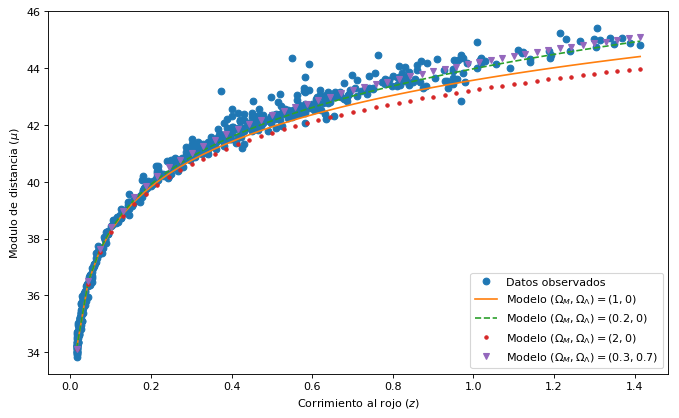

In [28]:
plt.figure(figsize=(10,6), dpi=80)
plt.plot(rojo,mod,'o',x,mu_1,'-',x,mu_2,'--',x,mu_3,'.',x,mu_4,'v')
plt.ylabel(r'Modulo de distancia ($\mu$)')
plt.xlabel(r'Corrimiento al rojo ($z$)')
plt.legend(('Datos observados',r'Modelo $(\Omega_M,\Omega_\Lambda)=(1,0)$',r'Modelo \
$(\Omega_M,\Omega_\Lambda)=(0.2,0)$',r'Modelo $(\Omega_M,\Omega_\Lambda)=(2,0)$',r'Modelo \
$(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$',),loc=0)
plt.show()

A partir del gráfico podemos decir que el modelo que mejor se ajusta a los datos es el modelo $(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$. Para corroborar esto, calculemos la suma de los residuos cuadráticos de cada modelo:

In [29]:
r1=[]
r2=[]
r3=[]
r4=[]

for i in range(len(rojo)):
    r1.append((mod[i]-Mod(rojo[i],1,0))**2)
    r2.append((mod[i]-Mod(rojo[i],0.2,0))**2)
    r3.append((mod[i]-Mod(rojo[i],2,0))**2)
    r4.append((mod[i]-Mod(rojo[i],0.3,0.7))**2)

R=[np.sum(r1),np.sum(r2),np.sum(r3),np.sum(r4)]

Notando como modelo 1 al modelo $(\Omega_M,\Omega_\Lambda)=(1,0)$, con modelo 2 al modelo 
$(\Omega_M,\Omega_\Lambda)=(0.2,0)$, con modelo 3 al modelo $(\Omega_M,\Omega_\Lambda)=(2,0)$ y con modelo 4 
al modelo $(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$, tenemos:

In [30]:
print("Modelo   Sum. Residuales cuadráticos")
for i in range(len(R)):
    print("  ",i+1,"           ",'{:f}'.format(R[i]))

Modelo   Sum. Residuales cuadráticos
   1             99.759404
   2             49.997995
   3             186.248442
   4             41.611139


De los calculos anterior podemos comprobar que el modelo que mejor se ajusta a los datos es el modelo $(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$ ya que cuenta con la menor suma de los residuales cuadráticos entre todos los modelos dados.

### Punto 9
Vectorizamos primero las funciones a usar en la función de error:

In [31]:
Mod=np.vectorize(Mod)
D_L=np.vectorize(D_L)

Definimos la función de error:

In [32]:
def f_err(omega,x,y,z):
    if (omega[0]>1 or omega[0]<0) or (omega[1]>1 or omega[1]<0):
        return 99999999999999999999999999999999999999999999999999999
    else:
        return (y-Mod(x,omega[0],omega[1]))/z

Definimos ahora la rutina de minimización:

In [33]:
def Min(a,b):
    x_0=(a,b)
    omega,c=leastsq(f_err,x_0,args=(rojo,mod,er))
    return omega

Probemos la rutina anterior considerando diferentes puntos de partida y a su vez calculemos la suma de los residuos cuadráticos para cada modelo:

In [34]:
print("Omega_M inicial   Omega_A inicial   Omega_M ajustado   Omega_A ajustado   Sum. Residuales")
for i in range(0,5):
    a=random.uniform(0,1)
    b=random.uniform(0,1)
    print("   ",'{:f}'.format(a),"        ",'{:f}'.format(b),"        ",'{:f}'.format(Min(a,b)[0]),"     \
    ",'{:f}'.format(Min(a,b)[1]),"    ",(f_err(Min(a,b),rojo,mod,er)**2).sum())

Omega_M inicial   Omega_A inicial   Omega_M ajustado   Omega_A ajustado   Sum. Residuales
    0.864525          0.260173          0.255961           0.600426      1235.7050632898322
    0.936760          0.167605          0.255963           0.600429      1235.7050632973142
    0.703281          0.209090          0.255960           0.600423      1235.705063287105
    0.355399          0.625346          0.255960           0.600423      1235.7050632871906
    0.335359          0.204213          0.255962           0.600427      1235.7050632894832


Note que en los cinco puntos de partida probados, todos convergen a la misma solución; la cual es aproximadamente $(\Omega_M,\Omega_\Lambda)=(0.2559,0.6004)$. El mejor modelo sería aproximadamente $(\Omega_M,\Omega_\Lambda)=(0.255960,0.600423)$ ya que tiene la menor suma de los residuales cuadráticos en los modelos considerados. Note también que este resultado es cercano al modelo $\Lambda CDM$.